In [1]:
from Functions import *
%run EnergyModel_DB.ipynb
from neuralflow import energy_model
import matplotlib.pyplot as plt, matplotlib.gridspec as gridspec
import pickle
import sys
sys.path.append('/Users/daniel/Downloads/Engel Lab Stuff')
import os
import random as rand

In [2]:
# Cell 1: initialize EnergyModel with the ramping dynamics and generate 50 trials of data from it.

# Specifies the parameters of the EnergyModel: ramping dynamics (linear potential), narrow 
# zero-centered p0(x) distribution, 2 neurons with linear and non-linear firing rate functions
EnergyModelParams={
               'peq_model': {'model': 'double_well', 'params': {'xmin': 0.6, 'xmax': 0.0, 'depth': 8}},
               'p0_model':{"model": "single_well", "params": {"miu": 200, "xmin": 0}},
               'D': 0.56,
               'firing_model':{'model': 'rectified_linear', 'params': {'r_slope': 100.0, 'x_thresh': -1}},
               # 'firing_model':[{'model': 'rectified_linear', 'params': {'r_slope': 100.0, 'x_thresh': -1}},
               #   {'model': 'rectified_linear', 'params': {'r_slope': -100.0, 'x_thresh': 1}}],
               'boundary_mode':'reflecting',    
               'verbose':True
               }

# Create an instance of EnergyModel class
# em_data_gen = energy_model.EnergyModel(**EnergyModelParams)
em_data_gen = energy_model.EnergyModel(**EnergyModelParams)



In [3]:
# Generate spike data from this model
num_trial = 100
# trials = [rand.uniform(0,1) for i in range(num_trial)]
# trials = np.append(trials,0)
# trials=sorted(trials)
# print(trials)
trial_start = np.zeros(num_trial) #[trials[i] for i in range(num_trial)]
trial_end = np.ones(num_trial) #[trials[i+1] for i in range(num_trial)]
data_ISI, time_bins, diff_traj = em_data_gen.generate_data(deltaT=0.00001,trial_start=trial_start,trial_end=trial_end)

100%|█████████████████████████████████████████| 100/100 [02:56<00:00,  1.76s/it]


In [4]:
# Cell 2

EnergyModelParams={
               'boundary_mode':'reflecting',  
                #'p0_model':{"model": "linear_pot", "params": {"slope": -2.65}},
                'peq_model':{"model": "uniform", "params": {}},
                'p0_model':{"model": "single_well", "params": {"miu": 200, "xmin": 0}},
               # 'firing_model':{'model': 'rectified_linear', 'params': {'r_slope': 100.0, 'x_thresh': -1}},
                'firing_model':[{"model": "linear", "params": {"r_slope": 50, "r_bias": 60}}],
                # {"model": "linear", "params": {"r_slope": 50, "r_bias": 60}}],
               'verbose':True
               }
em_fitting = energy_model.EnergyModel(**EnergyModelParams)


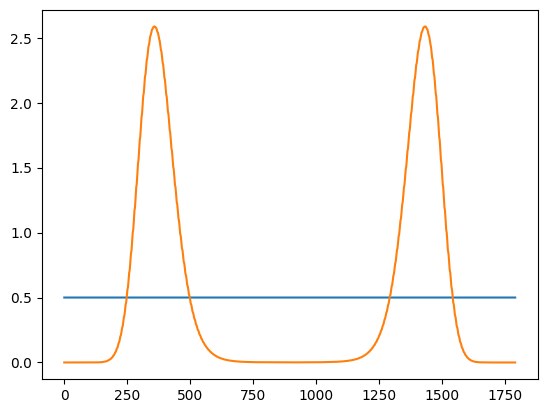

In [5]:
plt.plot(em_fitting.peq_[0,:])
plt.plot(em_data_gen.peq_[0,:])
plt.show()

In [6]:
# Cell 3

# Define optimization parameters: number of iterations and learning rate
learning_rate = 0.01
number_of_iterations = 10

# Define optimization options
options={}
options['data']={'dataTR':data_ISI}#,'dataCV':data_ISI}
# options['optimization']={'gamma':{'F':learning_rate},'max_iteration':number_of_iterations}
# options['optimization']= {'gamma':{'F':learning_rate,'F0':learning_rate,'Fr':learning_rate,'C':learning_rate,'D':learning_rate},'max_iteration':number_of_iterations}

#  beta1=0.9, beta2=0.999, epsilon=1e-08

# Let us reinitialize the model to reset the initial guess paramters (it is useful if you want to execute this cell more
# than 1 time)
# Fit the model
####
options['optimization']= {'gamma':{'params_to_opt':['F','D','F0','Fr','C'],'alpha':learning_rate,'beta1':0.9,'beta2':0.999,'epsilon':10**(-8)},'max_iteration':number_of_iterations}
em_fitting = energy_model.EnergyModel(**EnergyModelParams)
e = em_fitting.fit(data = options['data'], optimizer = 'ADAM',optimization = options['optimization'],save={'path':"/Users/daniel/PycharmProjects/Engel_Rotation_Project/Data/Jan18_6",'stride':1})



Performing Estimation of the model parameters...
The chosen optimizer is: ADAM
Epoch 1, Iteration 0
Epoch 2, Iteration 0
Epoch 3, Iteration 0
Epoch 4, Iteration 0
Epoch 5, Iteration 0
Epoch 6, Iteration 0
Epoch 7, Iteration 0
Epoch 8, Iteration 0
Epoch 9, Iteration 0
Epoch 10, Iteration 0
Optmization finished


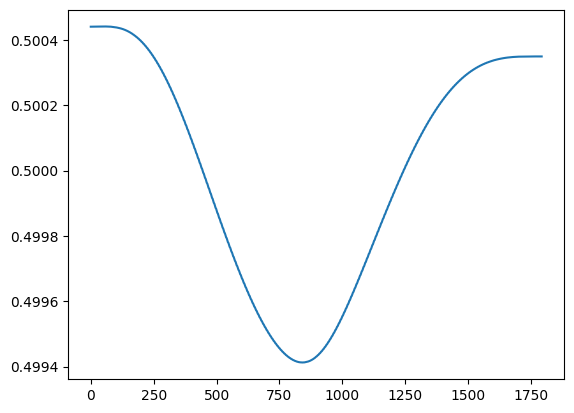

In [7]:
plt.plot(em_fitting.peq_[0,:])
plt.show()

In [98]:
em_fitting.D_

array([0.45956839])

In [35]:
# Cell 4: plot the results

# Extract negative loglikelihoods on each iteration
logliks = em_fitting.iterations_GD_['logliks']
fitted_peqs = em_fitting.iterations_GD_['peqs']

# Number of models to display
number_of_displayed_iterations = 6

fig=plt.figure(figsize=(20,8))
gs=gridspec.GridSpec(1,2,wspace=0.5,hspace=0.5);

# Cost function (negative loglikelihood) vs. iteration number
ax = plt.subplot(gs[0])
ax.set_title(r'Cost function, $-\log\mathscr{L}$', fontsize=14)
plt.xlabel('Iteration number', fontsize=14)
plt.ylabel(r'$-\log\mathscr{L}$', fontsize=14)

ax.plot(np.array(range(number_of_iterations+1)),logliks)

# Fitted models on different iterations
ax = plt.subplot(gs[1])
ax.set_title(r'Fitted and the ground-truth potentials', fontsize=14)
plt.xlabel(r'Latent state, $x$', fontsize=14)
plt.ylabel(r'$Potential, \Phi(x)$', fontsize=14)

# Feel free to manually define display iterations
# For example, if you want to display the results at iterations 0,3,10,50, 
# set display_iteration = np.array([0,3,10,50]).astype(int) 
display_iteration = np.linspace(0,number_of_iterations,number_of_displayed_iterations).astype('int')

for i in display_iteration:
    plt.plot(em_fitting.x_d_,-np.log(fitted_peqs[:,i]),label=f'Fitted, iteration {i}')

# Also plot the ground-truth model (that generated the data) for comparison
plt.plot(em_data_gen.x_d_,-np.log(em_data_gen.peq_),label=f'Ground-truth',color='black')

plt.legend()

AttributeError: 'EnergyModel' object has no attribute 'iterations_GD_'